<a href="https://colab.research.google.com/github/MadmanMarble/MadmanMarble/blob/main/multi_class_U_Net_Model_(11_march_2024).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# multi-class u-net model

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
pip install rasterio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 44.6 MB/s eta 0:00:00


In [4]:
import rasterio

In [5]:
from sklearn.model_selection import train_test_split
import shutil

In [8]:
directory_path = "/content/drive/MyDrive/DeepLearning_Project/planet_OneYear/images"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

There are 2825 files in /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/images.


In [9]:
directory_path = "/content/drive/MyDrive/DeepLearning_Project/planet_OneYear/labels"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

There are 2825 files in /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/labels.


In [10]:
# Ensure the lists are sorted so that images and labels correspond to each other
planet_images = sorted(glob.glob(f"/content/drive/MyDrive/DeepLearning_Project/planet_OneYear/images/*.tif"))
planet_labels = sorted(glob.glob(f"/content/drive/MyDrive/DeepLearning_Project/planet_OneYear/labels/*.tif"))

# Split the file paths into training and testing sets (80% train, 20% test)
train_images_paths, validation_images_paths, train_labels_paths, validation_labels_paths = train_test_split(
    planet_images, planet_labels, test_size=0.15, random_state=42)

In [11]:
#  1 minute
destination = '/content/validation_labels'
os.makedirs(destination, exist_ok=True)
for file in validation_labels_paths:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/labels/1903_nwi_ccap_filled_utm4.tif to /content/validation_labels/1903_nwi_ccap_filled_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/labels/548_nwi_ccap_filled_utm4.tif to /content/validation_labels/548_nwi_ccap_filled_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/labels/2218_nwi_ccap_filled_utm4.tif to /content/validation_labels/2218_nwi_ccap_filled_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/labels/794_nwi_ccap_filled_utm4.tif to /content/validation_labels/794_nwi_ccap_filled_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/labels/1915_nwi_ccap_filled_utm4.tif to /content/validation_labels/1915_nwi_ccap_filled_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/labels/1199_nwi_ccap_filled_utm4.tif to /content/validation_labels/1199_nwi_ccap_filled_utm4.tif
Copied /content/drive/MyDr

In [12]:
# 424 files
directory_path = "/content/validation_labels"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

There are 424 files in /content/validation_labels.


In [13]:
#  9 minute
destination = '/content/train_labels'
os.makedirs(destination, exist_ok=True)
for file in train_labels_paths:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/labels/361_nwi_ccap_filled_utm4.tif to /content/train_labels/361_nwi_ccap_filled_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/labels/2248_nwi_ccap_filled_utm4.tif to /content/train_labels/2248_nwi_ccap_filled_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/labels/143_nwi_ccap_filled_utm5.tif to /content/train_labels/143_nwi_ccap_filled_utm5.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/labels/2655_nwi_ccap_filled_utm4.tif to /content/train_labels/2655_nwi_ccap_filled_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/labels/66_nwi_ccap_filled_utm5.tif to /content/train_labels/66_nwi_ccap_filled_utm5.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/labels/885_nwi_ccap_filled_utm4.tif to /content/train_labels/885_nwi_ccap_filled_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneY

In [14]:
# 2401 files
directory_path = "/content/train_labels"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

There are 2401 files in /content/train_labels.


In [15]:
#  2 minute
destination = '/content/validation_images'
os.makedirs(destination, exist_ok=True)
for file in validation_images_paths:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/images/1903_planet_stack_utm4.tif to /content/validation_images/1903_planet_stack_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/images/548_planet_stack_utm4.tif to /content/validation_images/548_planet_stack_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/images/2218_planet_stack_utm4.tif to /content/validation_images/2218_planet_stack_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/images/794_planet_stack_utm4.tif to /content/validation_images/794_planet_stack_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/images/1915_planet_stack_utm4.tif to /content/validation_images/1915_planet_stack_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/images/1199_planet_stack_utm4.tif to /content/validation_images/1199_planet_stack_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneY

In [16]:
# 424 files
directory_path = "/content/validation_images"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

There are 424 files in /content/validation_images.


In [17]:
#  12 minute
destination = '/content/train_images'
os.makedirs(destination, exist_ok=True)
for file in train_images_paths:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/images/361_planet_stack_utm4.tif to /content/train_images/361_planet_stack_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/images/2248_planet_stack_utm4.tif to /content/train_images/2248_planet_stack_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/images/143_planet_stack_utm5.tif to /content/train_images/143_planet_stack_utm5.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/images/2655_planet_stack_utm4.tif to /content/train_images/2655_planet_stack_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/images/66_planet_stack_utm5.tif to /content/train_images/66_planet_stack_utm5.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/images/885_planet_stack_utm4.tif to /content/train_images/885_planet_stack_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/planet_OneYear/images/66_planet_stack_utm4.tif 

In [18]:
# 2401 files
directory_path = "/content/train_images"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

There are 2401 files in /content/train_images.


In [19]:
train_images = sorted(glob.glob(f"/content/train_images/*.tif"))
train_labels = sorted(glob.glob(f"/content/train_labels/*.tif"))

validation_images = sorted(glob.glob(f"/content/validation_images/*.tif"))
validation_labels= sorted(glob.glob(f"/content/validation_labels/*.tif"))



In [20]:
print(f"there are {len(train_images)} images for training")
print(f"there are {len(train_labels)} labels for training")
print(f"there are {len(validation_images)} images for validation")
print(f"there are {len(validation_labels)} labels for validation")

there are 2401 images for training
there are 2401 labels for training
there are 424 images for validation
there are 424 labels for validation


In [23]:
img_height = 384
img_width = 384
n_classes= 13 # how many classes in the labels?
batch_size = 8

In [ ]:
# from tensorflow.keras.utils import Sequence, to_categorical
# import numpy as np
# import rasterio
# import cv2

# class DataGenerator(Sequence):
#     def __init__(self, image_files, label_files, img_height, img_width, batch_size, num_classes):
#         self.image_files = image_files
#         self.label_files = label_files
#         self.img_height = img_height
#         self.img_width = img_width
#         self.batch_size = batch_size
#         self.num_classes = num_classes


#     def __len__(self):
#         return int(np.ceil(len(self.image_files) / self.batch_size))

#     def __getitem__(self, index):
#         # Determine batch file paths
#         image_batch_files = self.image_files[index * self.batch_size : (index + 1) * self.batch_size]
#         label_batch_files = self.label_files[index * self.batch_size : (index + 1) * self.batch_size]
#         # Load and process images and labels
#         batch_images, batch_labels = self.load_images_and_labels(image_batch_files, label_batch_files)
#         return batch_images, batch_labels

#     def load_and_reshape_image(self, image_path, normalize=True):
#         with rasterio.open(image_path) as src:
#             image = src.read().transpose((1, 2, 0))
#             if image.shape[:2] != (self.img_height, self.img_width):
#                 image = cv2.resize(image, (self.img_width, self.img_height), interpolation=cv2.INTER_NEAREST)

#             if normalize:
#                 # Normalize the image data to 0-1 range
#                 image = image.astype(np.float32) / 255.0

#         return image


#     def load_images_and_labels(self, image_files, label_files):
#         images = []
#         labels = []

#         for image_file in image_files:
#             image = self.load_and_reshape_image(image_file)
#             images.append(image)

#         for label_file in label_files:
#             label = self.load_and_reshape_image(label_file, normalize=False)
#             label = label.astype(np.uint8)
#             label = to_categorical(label, num_classes=self.num_classes)
#             labels.append(label)

#         # images = [self.load_and_reshape_image(image_file) for image_file in image_files]
#         # labels = [self.load_and_reshape_image(label_file, normalize=False) for label_file in label_files]
#         # # Here, assuming labels are categorical and do not require normalization like images
#         # # For segmentation tasks, ensure labels are processed according to your task requirements
#         # labels = [to_categorical(label, num_classes=self.num_classes) for label in labels]
#         return np.array(images), np.array(labels)


In [22]:
from tensorflow.keras.utils import Sequence, to_categorical
import numpy as np
import rasterio
import cv2

class DataGenerator(Sequence):
    def __init__(self, image_files, label_files, img_height, img_width, batch_size, num_classes):
        self.image_files = image_files
        self.label_files = label_files
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.num_classes = num_classes

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        image_batch_files = self.image_files[index * self.batch_size : (index + 1) * self.batch_size]
        label_batch_files = self.label_files[index * self.batch_size : (index + 1) * self.batch_size]

        batch_images, batch_labels = self.load_images_and_labels(image_batch_files, label_batch_files)
        return batch_images, batch_labels

    def load_and_reshape_image(self, image_path):
        with rasterio.open(image_path) as src:
            image = src.read().transpose((1, 2, 0))
            if image.shape[:2] != (self.img_height, self.img_width):
                image = cv2.resize(image, (self.img_width, self.img_height), interpolation=cv2.INTER_NEAREST)
        return image

    def z_score_normalization(self, image):
        image = image.astype(np.float32)  # Ensure the image is in float format to handle division and large ranges
        min_val = np.min(image, axis=(0, 1), keepdims=True)
        max_val = np.max(image, axis=(0, 1), keepdims=True)
        range_val = max_val - min_val
        if np.any(range_val == 0):
            normalized_image = np.zeros(image.shape, dtype=np.float32)
        else:
            normalized_image = (image - min_val) / range_val
        return normalized_image

    def load_images_and_labels(self, image_files, label_files):
        images = [self.load_and_reshape_image(image_file) for image_file in image_files]
        labels = [self.load_and_reshape_image(label_file) for label_file in label_files]
        normalized_images = [self.z_score_normalization(image) for image in images]
        processed_labels = [to_categorical(label, num_classes=self.num_classes) for label in labels]
        return np.array(normalized_images), np.array(processed_labels)

In [36]:
# train_data_generator = DataGenerator(image_files, label_files, img_height, img_width, batch_size, num_classes)
# train_images
# train_labels
# validation_images
# validation_labels

train_data_generator = DataGenerator(train_images, train_labels, img_height, img_width, batch_size, n_classes)
val_data_generator = DataGenerator(validation_images, validation_labels, img_height, img_width, batch_size, n_classes)

In [37]:
batch_images, batch_labels = train_data_generator.__getitem__(0)

In [26]:
batch_images.shape

(8, 384, 384, 5)

In [27]:
batch_labels.shape

(8, 384, 384, 13)

In [ ]:
# batch_images

In [ ]:
# batch_labels

In [28]:
# prompt: print how many files are in y_test
print('Number of files in train labels:', len(batch_images))
print('Number of files in test labels:', len(batch_images))
batch_images.shape

Number of files in train labels: 8
Number of files in test labels: 8


(8, 384, 384, 5)

In [29]:
from keras.utils import to_categorical
import keras
# import TenserFlow classes and functions
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization

In [38]:
def multi_unet_model(n_classes=13, IMG_HEIGHT=384, IMG_WIDTH=384, IMG_CHANNELS=5):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = BatchNormalization()(u6)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(u6)
    u6 = BatchNormalization()(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c6)
    u6 = BatchNormalization()(u6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
# def multi_unet_model(n_classes=13, IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=13):
# #Build the model
#     inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#     ### [First half of the network: downsampling inputs] ###

#     # Entry block
#     x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     previous_block_activation = x  # Set aside residual

#     # Blocks 1, 2, 3 are identical apart from the feature depth.
#     for filters in [64, 128, 256]:
#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

#         # Project residual
#         residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
#             previous_block_activation
#         )
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     ### [Second half of the network: upsampling inputs] ###

#     for filters in [256, 128, 64, 32]:
#         x = layers.Activation("relu")(x)
#         x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation("relu")(x)
#         x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.UpSampling2D(2)(x)

#         # Project residual
#         residual = layers.UpSampling2D(2)(previous_block_activation)
#         residual = layers.Conv2D(filters, 1, padding="same")(residual)
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     # Add a per-pixel classification layer
#     outputs = layers.Conv2D(n_classes, 3, activation="softmax", padding="same")(x)

#     # Define the model
#     model = Model(inputs=[inputs], outputs=[outputs])

#     return model

In [39]:
model = multi_unet_model(n_classes=13, IMG_HEIGHT=384, IMG_WIDTH=384, IMG_CHANNELS=5)

In [ ]:
print(model.summary()) # 1946973

In [32]:
from tensorflow.keras.optimizers import Adam

In [40]:
model.compile(optimizer= Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', "categorical_accuracy"])

In [41]:
import tensorflow as tf

Modle_Checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'the_best_model.h5', # You also can provide full path to the folder you want to save your model to
    monitor='val_loss',
    monitor= 'val_accuracy'  # Monitor other things like val_accuracy or accuracy
    save_best_only='True', # Make sure to save only the best model
    verbose=1
)

# Early_Stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', # Same as the
#     patience=5, # Wait for 5 epochs before stopping the training
#     verbose=1,
#     restore_best_weights='True', # Restore model weights from the epoch with the best value of the monitored quantity.
#     min_delta=0.1
# )

Tensor_Board = tf.keras.callbacks.TensorBoard('./tb_logs/run_logs')



In [42]:
model.fit(train_data_generator, validation_data= val_data_generator, epochs=5, callbacks=[Modle_Checkpoint, Tensor_Board],shuffle=True)

Epoch 1/5
301/301 [==============================] - ETA: 0s - loss: 2.2959 - accuracy: 0.3095 - categorical_accuracy: 0.3095
Epoch 1: val_loss improved from inf to 1.97064, saving model to the_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


301/301 [==============================] - 197s 570ms/step - loss: 2.2959 - accuracy: 0.3095 - categorical_accuracy: 0.3095 - val_loss: 1.9706 - val_accuracy: 0.3719 - val_categorical_accuracy: 0.3719
Epoch 2/5
301/301 [==============================] - ETA: 0s - loss: 2.0081 - accuracy: 0.3625 - categorical_accuracy: 0.3625
Epoch 2: val_loss improved from 1.97064 to 1.83043, saving model to the_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


301/301 [==============================] - 168s 558ms/step - loss: 2.0081 - accuracy: 0.3625 - categorical_accuracy: 0.3625 - val_loss: 1.8304 - val_accuracy: 0.4000 - val_categorical_accuracy: 0.4000
Epoch 3/5
301/301 [==============================] - ETA: 0s - loss: 1.8569 - accuracy: 0.3750 - categorical_accuracy: 0.3750
Epoch 3: val_loss improved from 1.83043 to 1.71347, saving model to the_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


301/301 [==============================] - 170s 564ms/step - loss: 1.8569 - accuracy: 0.3750 - categorical_accuracy: 0.3750 - val_loss: 1.7135 - val_accuracy: 0.4164 - val_categorical_accuracy: 0.4164
Epoch 4/5
301/301 [==============================] - ETA: 0s - loss: 1.7892 - accuracy: 0.3891 - categorical_accuracy: 0.3891
Epoch 4: val_loss did not improve from 1.71347
301/301 [==============================] - 160s 529ms/step - loss: 1.7892 - accuracy: 0.3891 - categorical_accuracy: 0.3891 - val_loss: 1.7247 - val_accuracy: 0.4273 - val_categorical_accuracy: 0.4273
Epoch 5/5
301/301 [==============================] - ETA: 0s - loss: 1.7705 - accuracy: 0.3993 - categorical_accuracy: 0.3993
Epoch 5: val_loss did not improve from 1.71347
301/301 [==============================] - 165s 547ms/step - loss: 1.7705 - accuracy: 0.3993 - categorical_accuracy: 0.3993 - val_loss: 1.9320 - val_accuracy: 0.3305 - val_categorical_accuracy: 0.3305


In [ ]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', "categorical_accuracy"])
# callbacks = [keras.callbacks.ModelCheckpoint(filepath='model_100.h5', save_best_only=True)]

# callbacks = [keras.callbacks.ModelCheckpoint(filepath='model_032224_1216_lr001.h5', save_best_only=True)]

# Trying to predict on test data

In [43]:
model.compile(optimizer= Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', "categorical_accuracy"])

In [44]:
import numpy as np
import cv2
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback
import rasterio

class SavePredictionCallback(Callback):
    def __init__(self, test_image_dir, test_label_dir, model_input_size, output_folder, epoch_frequency=5):
        super().__init__()
        self.test_image_dir = test_image_dir
        self.test_label_dir = test_label_dir  # Optional: Use if you want to compare predictions with actual labels
        self.model_input_size = model_input_size
        self.output_folder = output_folder
        self.epoch_frequency = epoch_frequency
        self.image_files = [os.path.join(test_image_dir, f) for f in os.listdir(test_image_dir) if f.endswith('.tif')]

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epoch_frequency == 0:
            for image_path in self.image_files:
                with rasterio.open(image_path) as src:
                    image = src.read(out_shape=(src.count, self.model_input_size[0], self.model_input_size[1]),
                                     resampling=rasterio.enums.Resampling.nearest)
                    image = np.transpose(image, (1, 2, 0))
                    image = np.expand_dims(image, axis=0)  # Add batch dimension
                    image = image / np.max(image)  # Normalize
                    meta = src.meta

                prediction = self.model.predict(image)
                prediction_image = np.argmax(prediction, axis=-1)[0, :, :]

                output_path = os.path.join(self.output_folder, f"epoch_{epoch+1}_{os.path.basename(image_path)}")
                meta = src.meta
                meta.update(dtype=rasterio.uint8, count=1, nodata=None)  # what was here previously: (dtype=rasterio.uint8, count=1)

                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(prediction_image.astype(rasterio.uint8), 1)

# Define model input size and paths

IMG_HEIGHT, IMG_WIDTH = img_height, img_width
test_image_dir = '/content/drive/MyDrive/DeepLearning_Project/planet_OneYear/test_dataset/test_images/'
test_label_dir = '/content/drive/MyDrive/DeepLearning_Project/planet_OneYear/test_dataset/test_labels/'  # Optional
output_folder = '/content/drive/MyDrive/DeepLearning_Project/planet_OneYear/test_dataset/model_03222023_1255/'

# Make sure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# Instantiate the callback
save_pred_callback = SavePredictionCallback(
    test_image_dir=test_image_dir,
    test_label_dir=test_label_dir,
    model_input_size=(IMG_HEIGHT, IMG_WIDTH),
    output_folder=output_folder,
    epoch_frequency=5
)

In [50]:
model.compile(optimizer= Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', "categorical_accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/DeepLearning_Project/planet_OneYear/test_dataset/model_03222023_1255/model_03222023_1255.h5', monitor = 'val_loss', save_best_only=True),
    save_pred_callback
]
Tensor_Board = tf.keras.callbacks.TensorBoard('./tb_logs_model_03222023_1255/run_logs')

In [ ]:
model.fit(train_data_generator, validation_data= val_data_generator, epochs=50, callbacks=[callbacks, Tensor_Board],shuffle=True)

# using the model to predict

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import rasterio
# from tensorflow.keras.preprocessing.image import array_to_img
# import PIL.ImageOps
# from PIL import Image
# import matplotlib.patches as mpatches
# import matplotlib.colors as mcolors

# class_names = ['Unclassified', 'Water', 'Forested Wetland', 'Emergent Wetland', 'Forested/Shrub Wetland', 'Aquatic Bed', 'Developed', 'Agriculture', 'Grassland', 'Forest', 'Shrubland']
# colors = ['dimgrey', 'cornflowerblue', 'violet', 'teal', 'orange', 'mediumblue', 'lightgrey', 'saddlebrown', 'wheat', 'lightyellow', 'forestgreen', 'peru']
# cmap = mcolors.ListedColormap(colors)


In [52]:
from tensorflow.keras.models import load_model

# Replace 'path/to/your/model.h5' with the actual path to your saved model
model = load_model('/content/the_best_model.h5')


In [59]:
from tensorflow.image import resize

def load_and_preprocess_image(image_path, expected_size):
    with rasterio.open(image_path) as src:
        # Read the imagery tile, assuming it's multi-band
        image = src.read()

        # Optionally, select the first 3 bands if that's what your model expects
        if image.shape[0] > 5:
            image = image[:5, :, :]

        # Transpose from (bands, height, width) to (height, width, bands)
        image = np.transpose(image, (1, 2, 0))

        # Resize the image to the expected size (e.g., 128x128)
        image = resize(image, [expected_size, expected_size])

        # Normalize if your model expects data to be normalized
        # min_val = np.min(image)
        # max_val = np.max(image)
        # range_val = max_val - min_val
        # image = (image - min_val) / range_val

        # Normalize if your model expects
        image = image / 2555.0  # Adjust based on your normalization method

        # Add batch dimension as model expects (batch_size, height, width, channels)
        image = np.expand_dims(image, axis=0)

        return image

# Example usage
image_path = '/content/drive/MyDrive/DeepLearning_Project/unet_planet_data/testing/images/821_planet_stack_utm4.tif'
expected_size = 384  # Example expected size, adjust as necessary
image = load_and_preprocess_image(image_path, expected_size)


In [61]:
prediction = model.predict(image)

# Process the prediction as needed (e.g., taking the argmax for classification tasks)
# For segmentation tasks:
predicted_mask = np.argmax(prediction, axis=-1)
predicted_mask = predicted_mask[0, :, :]  # Remove batch dimension

# Now, `predicted_mask` contains the predicted class for each pixel


1/1 [==============================] - 1s 868ms/step


In [62]:
predicted_mask

array([[ 1,  3,  1, ..., 10, 10, 10],
       [ 1,  1,  1, ..., 10, 10, 10],
       [ 1,  1,  1, ...,  6,  6, 10],
       ...,
       [ 1,  1,  1, ..., 10, 10, 10],
       [12, 12, 12, ..., 10, 10, 10],
       [ 6,  3,  3, ..., 10, 10, 10]])

In [ ]:
# pip install matplotlib

1/1 [==============================] - 1s 521ms/step


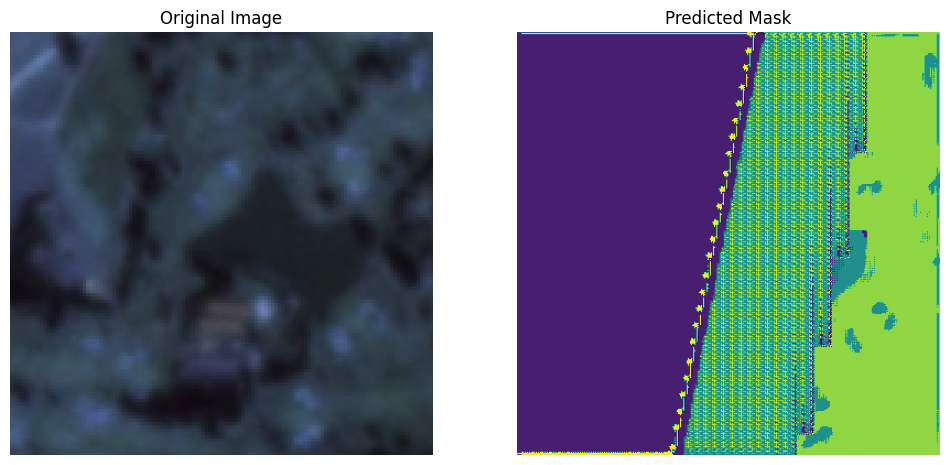

In [63]:
import matplotlib.pyplot as plt


def visualize_prediction(original_image, predicted_mask, figsize=(12, 6)):
    # Assuming original_image is in the format (height, width, channels)
    # and has already been normalized (e.g., pixel values range between 0 and 1)

    # If the original image has more than 3 channels, select the first three for visualization
    if original_image.shape[-1] > 3:
        original_image = original_image[:, :, :3]

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Display the original image
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Display the predicted mask
    # Assuming predicted_mask is 2D (height, width), you might want to add a colormap
    axes[1].imshow(predicted_mask, cmap='viridis')  # Use a colormap that suits your task
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')

    plt.show()

# Load your original image and preprocess it for prediction
# Assuming `image` is already loaded and preprocessed for prediction, as shown in the previous steps

# Make a prediction
prediction = model.predict(image)

# Convert prediction to a class mask
predicted_mask = np.argmax(prediction, axis=-1)[0, :, :]  # Remove batch dimension

# Visualize the original image and the prediction
# Note: You might need to adjust the preprocessing of `image` to ensure it's in the correct format for visualization


# adjusted_image = image * factor
adjusted_image = np.clip(image, 0, 1)  # Ensure values are within [0, 1]
visualize_prediction(adjusted_image[0], predicted_mask)

# visualize_prediction(image[0], predicted_mask)  # Pass the first item in the batch
